<b><h3>Import Libraries</h3></b>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

 <h3><b>Load and Preprocess Dataset</b></h3>
 <ul>
    <li>Load the pneumonia dataset and split into train, test, and validation sets</li>
    <li>Convert each set to numpy array and separate the images from the labels</li>
    <li>Print out the shape of the sets to ensure they have the expected size (<i>624, 4708, 524</i>)</li>
    <li>Normalise the pixel values to the range [0, 1]</li>
 </ul>

In [2]:
# Load the pneumonia dataset
train_ds = tfds.load('pneumonia_mnist', split='train', as_supervised=True, shuffle_files=True)
test_ds = tfds.load('pneumonia_mnist', split='test', as_supervised=True)
val_ds = tfds.load('pneumonia_mnist', split='val', as_supervised=True)

# Convert to numpy arrays and separate into training, testing, and validation sets
x_train = np.array([img.numpy() for img, _ in train_ds])
labels_train = np.array([label.numpy() for _, label in train_ds])

x_test = np.array([img.numpy() for img, _ in test_ds])
labels_test = np.array([label.numpy() for _, label in test_ds])

x_val = np.array([img.numpy() for img, _ in val_ds])
labels_val = np.array([label.numpy() for _, label in val_ds])

# Print the shapes of the datasets
print(f'Traning data: {labels_train.shape}')
print(f'Test data: {labels_test.shape}')
print(f'Validation data: {labels_val.shape}')

# Normalize the pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

Traning data: (4708,)
Test data: (624,)
Validation data: (524,)


<b><h3>Visualize data</h3></b>

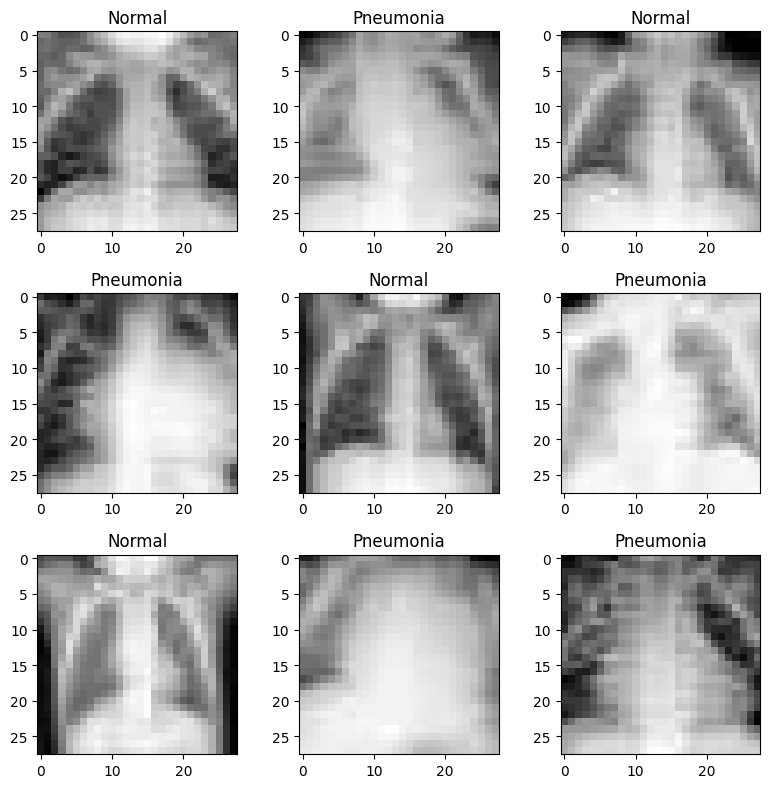

In [3]:
plt.subplots(3, 3, figsize=(8, 8))
plt.tight_layout()

for i in range(9):
    label = labels_train[i]
    image = x_train[i]

    # Plot
    plt.subplot(3, 3, i + 1)
    plt.title('Pneumonia' if label == 1 else 'Normal')
    plt.imshow(image, cmap='gray')
plt.show()

<b><h3>Build & Train Model</h3></b>
<p>The model was build using a Sequential model, which extracts features using Conv2D layers, reduces spatial size and computational cost using MaxPool2D, Flatten which reduces 2D feature maps into 1D vector, Dropout layer which randomly drops neurons to reduce overfitting, and Dense layers which are fully connected layers to learn complex reationships.</p>

In [4]:
net = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

net.summary()

c:\Users\varno\Documents\Projects\Skincaner_CNN\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,345 (474.00 KB)

 Trainable params: 121,345 (474.00 KB)

 Non-trainable params: 0 (0.00 B)

<p>The model is compiled using the ADAM optimized, binary_crossentropy as the loss function (due to the number of unique labels being 2), and it uses accuracy, precision, and recall as its metrics. Early stopping is also employed to ensure the model doesn't overfit.</p>
<p><i>Training time ~5 seconds</i></p>

In [5]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

net.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
history = net.fit(x_train, labels_train, validation_data=(x_val, labels_val), epochs=15, batch_size=256, callbacks=[early_stop])

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7160 - loss: 0.5744 - precision: 0.7409 - recall: 0.9493 - val_accuracy: 0.7424 - val_loss: 0.5230 - val_precision: 0.7424 - val_recall: 1.0000
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7523 - loss: 0.4836 - precision: 0.7505 - recall: 0.9980 - val_accuracy: 0.8550 - val_loss: 0.4130 - val_precision: 0.8470 - val_recall: 0.9820
Epoch 3/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8475 - loss: 0.3522 - precision: 0.8449 - recall: 0.9731 - val_accuracy: 0.8989 - val_loss: 0.2799 - val_precision: 0.9308 - val_recall: 0.9332
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8987 - loss: 0.2512 - precision: 0.9175 - recall: 0.9488 - val_accuracy: 0.9141 - val_loss: 0.2203 - val_precision: 0.9410 - val_recall: 0.9434
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9074 - loss: 0.2284 - precision: 0.9344 - recall: 0.9413 - val_accuracy: 0.9332 - val_loss: 0.1993 

<b><h3>Visualize and Analyse Model</h3></b>

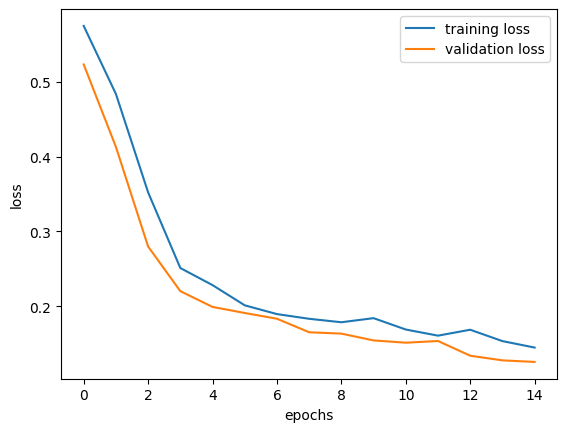

In [6]:
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

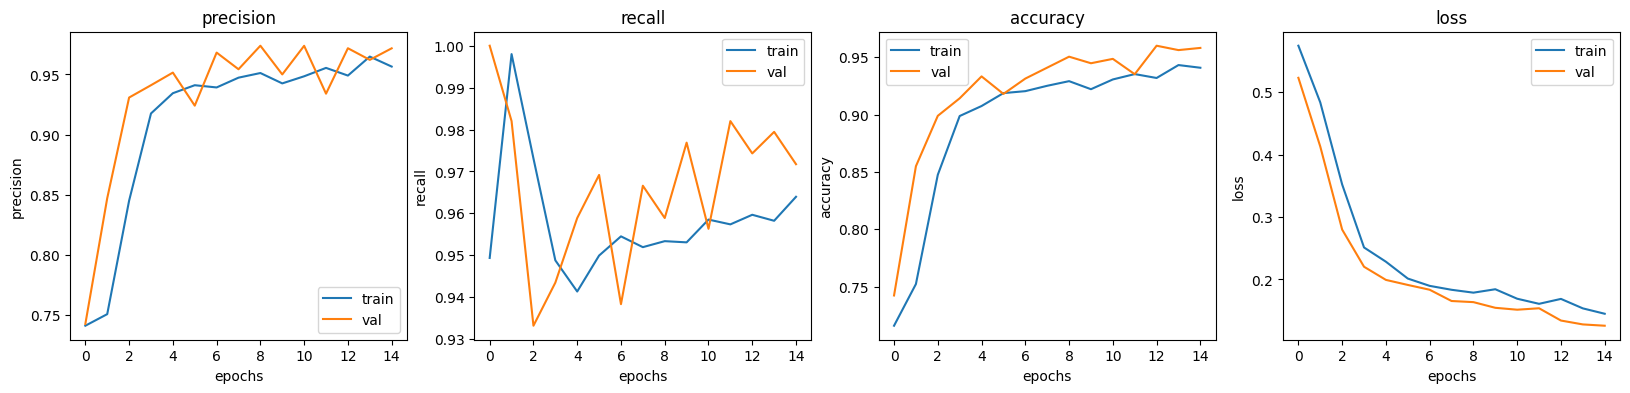

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title(f'Model{met}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].set_title(met)
    ax[i].legend(['train', 'val'])

In [8]:
outputs=net.predict(x_test)
labels_predicted = (outputs > 0.5).astype(int).flatten()

misclassified=sum(labels_predicted!=labels_test)
print(f'Percentage misclassified = {100*misclassified/labels_test.size: .2f}%')

correctlyclassified=sum(labels_predicted==labels_test)
print(f'Percentage correctly classified = {100*correctlyclassified/labels_test.size: .2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Percentage misclassified =  14.26%
Percentage correctly classified =  85.74%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


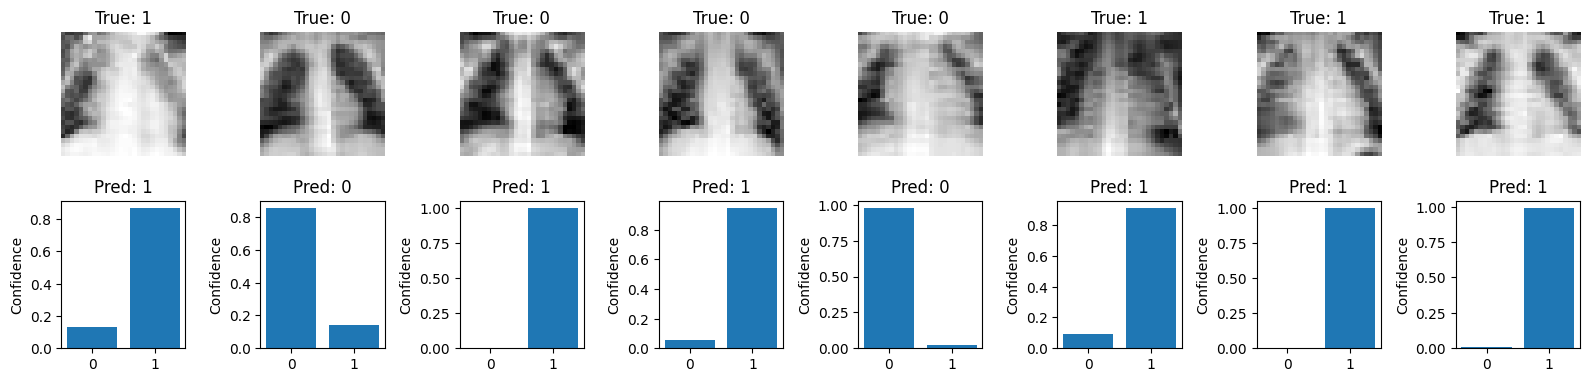

In [9]:
plt.figure(figsize=(16, 4))

for i in range(8):
    output = net.predict(x_test[i+10, :].reshape(1, 28, 28, 1))
    output = output[0, :]
    
    plt.subplot(2, 8, i + 1)
    plt.imshow(x_test[i, :, :, 0], cmap='gray')
    plt.title(f"True: {labels_test[i]}")
    plt.axis('off')
    
    plt.subplot(2, 8, 8 + i + 1)
    plt.bar(['0', '1'], [1 - output[0], output[0]])
    plt.ylabel('Confidence')
    plt.title(f"Pred: {int(output[0] > 0.5)}")

plt.tight_layout()
plt.show()